## Motion blur estimation and correction

The camera on the satellite is moving at 7 km/s, image resolution is 1 m/pixel.  Exposure is several hundred ms.

Position is (40.851646, 109.6288882).

*How to estimate and correct for motion blur?*

Assuming linear motion, image blur will cause a summation of pixel depth for each point in the image in the direction of motion.  For example, a dot will appear as a line since the image will move across the camera sensor during the exposure time.

Essentially, this can be thought of a convolution with a square wave.  To correct for motion blur, we must deconvolve it.

We begin by taking an example image and convolving it with a square wave.

In [74]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

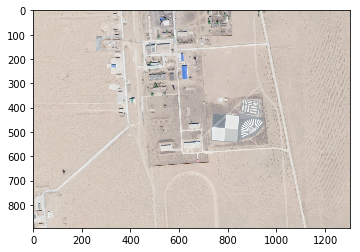

In [75]:
# First import and show image
image = imread("google_maps_china.png")
image = image[:,:,:3]/255 
# ^ Discard alpha channel, convert to 255-int to 1.0float
plt.imshow(image)

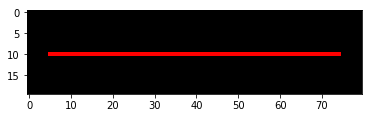

In [85]:
# Define square wave to convolve image with
nx,ny,nc = 20, 80, 3 # image.shape
kernel = np.zeros(shape=(nx,ny,nc),dtype=np.float64)

kernel[10:11, 5:75, 0] = 1

plt.imshow(kernel) 

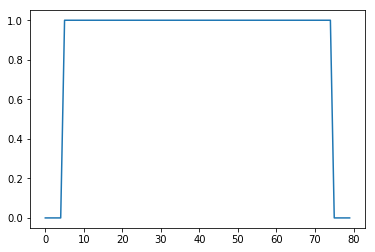

In [77]:
plt.plot(range(ny),kernel[10,:,0])

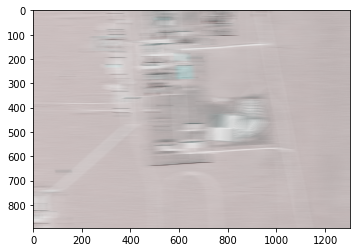

In [78]:
# Now we convolve the two
mag = np.sum(kernel)
blurred_image_slice = ndimage.convolve(image, kernel/mag)
#print(blurred_image_slice)
plt.imshow(blurred_image_slice)
plt.show()

Let's simplify the data for the sake of demonstration.  We will separate the red, green, and blue channels, and zoom out into a 100 x 100 pixel image - this way, we can quickly try out and compare a few deconvolution methods.  

Given the speed, 7e3 m/s, the resolution of 1 m/pixel and the exposure time, say 100e-3 s, we would expect the convolution to span 700 pixels in a 2048 pixel detector.  That's about 1/3 of the detector.  Let's say that satellite maneuvers can accommodate maybe half of this (?) so that the convolution takes up ~1/6 of the pixels, or 16 pixels on our 100 pixel-length test image.

*Image data will likely be e.g. 1024 x 1024 or 2048 x 2048 pixels, and it would be most efficient to use numpy indexing to do all the channels at once.*

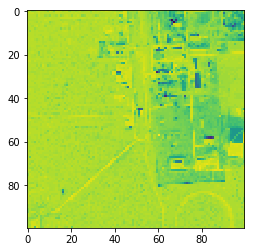

In [79]:
# Example image, using red channel (star)
from scipy import signal
plt.tight_layout()
image_r = image[:800:8,:800:8,0] #red channel

plt.imshow(image_r)
plt.show()

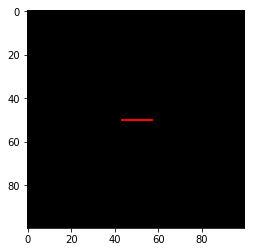

In [88]:
# Example kernel (psf)
nx,ny,nc = 100, 100, 3 # image.shape
kernel = np.zeros(shape=(nx,ny,nc),dtype=np.float64)

kernel[50:51, 43:58, 0] = 1
mag = np.sum(kernel)

plt.imshow(kernel) 

We will convolve the image with our kernel, and then implement a few deconvolution methods and compare.

For our baseline, we will do a "naïve" deconvolution, where we simply divide the two entities in Fourier space.

We then turn to the Wiener deconvolution, a very common non-iterative technique which uses a Wiener filter to minimize the mean square error.

C:\ProgramData\Anaconda3\lib\site-packages\skimage\restoration\deconvolution.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  data_spectrum = uft.urfft2(image.astype(np.float))


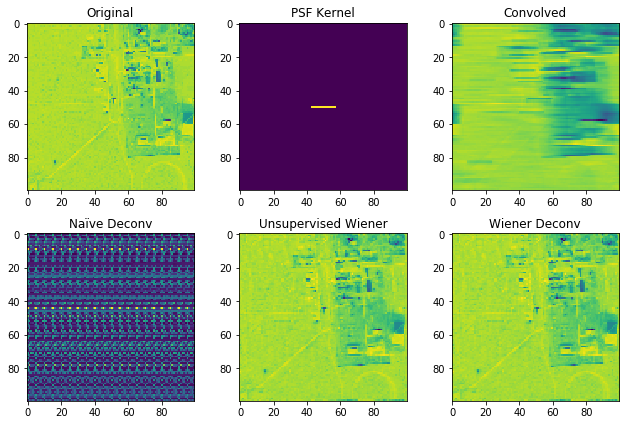

In [91]:
from scipy import stats
from scipy.fftpack import fftn, ifftn, fftshift, ifftshift

from skimage import color, data, restoration

def F(f):
    return fftshift(fftn(f))

def convolve(f, g):
    return fftshift(ifftn(ifftshift(F(f) * F(g))))

def deconvolve(f,g):
    return fftshift(ifftn(ifftshift(F(f) / F(g))))

def de_unsup_wiener(f, g):
    params = {'min_iter':200}
    return restoration.unsupervised_wiener(f, g, user_params=params)
  
def de_wiener(f, g, SNR=10):
    #https://en.wikipedia.org/wiki/Wiener_deconvolution
    Fg2 = np.absolute(F(g))**2
    return fftshift(fftn(F(f)/F(g) * Fg2/(Fg2 + 1/SNR)))
  
from scipy import signal


sx, sy = 100,100 # image_r.shape
n = 8
image_r = image[:sx*n:n,:sy*n:n,0]

psf = kernel[:,:, 0]/mag
ref = image_r.copy()

ref_conv = convolve(ref, psf)

ref_deconv    = deconvolve(ref_conv, psf)
ref_de_unsup_wiener, _= de_unsup_wiener(ref_conv, psf)
ref_de_wiener = de_wiener(ref_conv, psf,SNR=1e3) 
# ^ In reality, SNR should be calculated, but for the sake of demonstration, we give it as a constant.
ref_de_wiener = ref_de_wiener[::-1,::-1]

f, axes = plt.subplots(2,3,figsize=(9,6))

ax_orig = axes[0,0]
ax_orig.imshow(ref)
ax_orig.set_title("Original")

ax_psf = axes[0,1] 
ax_psf.imshow(psf)
ax_psf.set_title("PSF Kernel")

ax_conv = axes[0,2]
ax_conv.imshow(np.absolute(ref_conv))
ax_conv.set_title("Convolved")
 
ax_deconv= axes[1,0]
ax_deconv.imshow(np.absolute(ref_deconv))
ax_deconv.set_title("Naïve Deconv")    
    
ax_deconv= axes[1,1]
ax_deconv.imshow(np.absolute(ref_de_wiener))
ax_deconv.set_title("Unsupervised Wiener")

ax_wiener = axes[1,2]
ax_wiener.imshow(np.absolute(ref_de_wiener))
ax_wiener.set_title("Wiener Deconv")


                 
plt.tight_layout()
plt.show()


The "naïve" deconvolution did not provide anything resembling the original image.

The Unsupervised Wiener and the Wiener deconvolution produced similar results and both seemed to have done a reasonable job. Depending on what deliverables are meant to come from these images, it would shape the discussion of which deconvolution may be better, but in general errors seem to be around or below 10% (more discussion on errors later).

Moving on, we next try out a couple iterative techniques.  The Richardson-Lucy is a common algorithm which decomposes the image the the psf and iteratively convolves an "estimate" image until it converges to the maximaum likelihood solution for the original image. There is also the Poisson Maximum a posteriori estimation (similar to the aforementioned bug uses an exponential operation, assuring non-negativity and non-linearity for high-resolution).  We will try both.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide


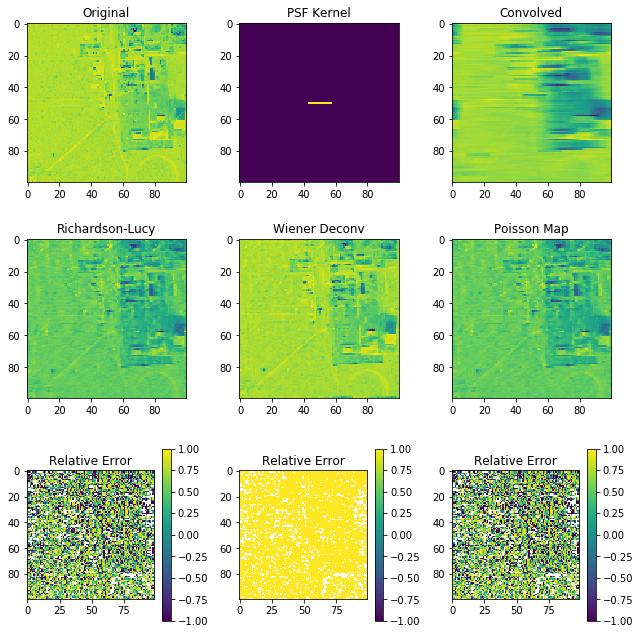

In [82]:
from scipy import stats
from scipy.fftpack import fftn, ifftn, fftshift, ifftshift


def F(f):
    return fftshift(fftn(f))

def convolve(f, g):
    return fftshift(ifftn(ifftshift(F(f) * F(g))))

def de_rich_lucy(f, g, iters=10):
    u = f.copy() #initial guess
    for ix in range(iters):
        u = u * convolve(f/convolve(u,g),np.flip(g, axis=-1))
    return np.absolute(u)

def de_poisson_map(f, g, iters=10):
    u = f.copy() #initial guess
    for ix in range(iters):
        u = u * np.exp(convolve(f/convolve(u,g),np.flip(g, axis=-1))-1)
    return np.absolute(u)
  
def de_wiener(f, g, SNR=10):
    #https://en.wikipedia.org/wiki/Wiener_deconvolution
    Fg2 = np.absolute(F(g))**2
    return fftshift(fftn(F(f)/F(g) * Fg2/(Fg2 + 1/SNR)))
  
from scipy import signal

sx, sy = 100,100 # image_r.shape
n = 8
image_r = image[:sx*n:n,:sy*n:n,0] 
 
psf = kernel[:,:, 0]/mag

ref = image_r.copy()

f, axes = plt.subplots(3,3,figsize=(9,9))

ref_conv = convolve(ref, psf)


ref_deconv    = deconvolve(ref_conv, psf)
ref_de_rich_lucy = de_rich_lucy(ref_conv, psf, iters=120)
ref_de_poisson_map = de_poisson_map(ref_conv, psf, iters=120)
ref_de_wiener = de_wiener(ref_conv, psf,SNR=1e3)
ref_de_wiener = ref_de_wiener[::-1,::-1]


ax_orig = axes[0,0]
ax_orig.imshow(ref)
ax_orig.set_title("Original")

ax_psf = axes[0,1] 
ax_psf.imshow(psf)
ax_psf.set_title("PSF Kernel")

ax_conv = axes[0,2]
ax_conv.imshow(np.absolute(ref_conv))
ax_conv.set_title("Convolved")
                  
ax_rich_lucy= axes[1,0]
ax_rich_lucy.imshow(np.absolute(ref_de_rich_lucy))
ax_rich_lucy.set_title("Richardson-Lucy")

ax_wiener = axes[1,1]
ax_wiener.imshow(np.absolute(ref_de_wiener))
ax_wiener.set_title("Wiener Deconv")

#scaling = np.max(ref)/np.max(np.real(ref_de_rich_lucy))
                   
ax_poisson = axes[1,2]
ax_poisson.imshow(np.absolute(ref_de_poisson_map))
ax_poisson.set_title("Poisson Map")


#In image, it's important to capture features, which are distinguished by gradients.
#We use horizontal since this is the direction it was blurred in.
grad_horiz_rl = np.diff(ref_de_rich_lucy)
grad_horiz_wiener = np.diff(ref_de_rich_lucy)
grad_horiz_pois = np.diff(ref_de_poisson_map)
grad_horiz_ref = np.diff(ref)

#Normalize for error calculation
scaling_de_rich_lucy = np.max(ref)/np.max(np.real(ref_de_rich_lucy))
scaling_de_wiener = np.max(ref)/np.max(np.real(ref_de_wiener))
scaling_de_poisson_map = np.max(ref)/np.max(np.real(ref_de_poisson_map))

ax_error_rl = axes[2,0]
cbar1 = ax_error_rl.imshow((np.absolute(grad_horiz_ref)-
                            scaling_de_rich_lucy*np.absolute(grad_horiz_rl))/(np.absolute(grad_horiz_ref)))
ax_error_rl.set_title("Relative Error")
cbar1.set_clim(vmin=-1, vmax=1)
f.colorbar(cbar1, ax=ax_error_rl)

ax_error_wiener = axes[2,1]
cbar2 =ax_error_wiener.imshow((np.absolute(grad_horiz_ref)-
                               scaling_de_wiener*np.absolute(grad_horiz_wiener))/(np.absolute(grad_horiz_ref)))
ax_error_wiener.set_title("Relative Error")
cbar2.set_clim(vmin=-1, vmax=1)
f.colorbar(cbar2, ax=ax_error_wiener)

ax_error_poisson = axes[2,2]
cbar3 = ax_error_poisson.imshow((np.absolute(grad_horiz_ref)-
                                 scaling_de_poisson_map*np.absolute(grad_horiz_pois))/(np.absolute(grad_horiz_ref)))
ax_error_poisson.set_title("Relative Error")
cbar3.set_clim(vmin=-1, vmax=1)
f.colorbar(cbar3, ax=ax_error_poisson)


plt.tight_layout()
plt.show()

A good topic of discussion would be how to evaluate the error in these deconvolutions.  For example, the relative difference in images could be misleading, one could draw a solid block of the mean pixel depth of the image and for many images get a very low error. 

As mentioned before, we often find images informative because we see features in them which we can measure and evaluate.  For this reason, I thought taking the gradient (in the horizontal direction, since that was the direction of blur) would help to show whether the deconvolutions closely captured the appearance of features.  

Doing this, we see that the iterative methods produce a range of errors, while the Wiener produces a constant error.  It's not obvious to me which is preferrable.

We compare now the "error" of the convolution to the original...

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


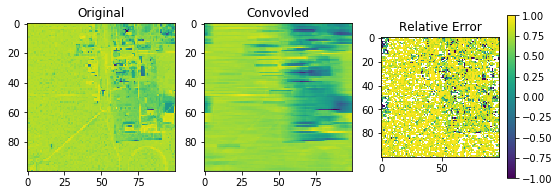

In [83]:
f, axes = plt.subplots(1,3, figsize=(9,3))

ax_orig = axes[0]
ax_orig.imshow(ref)
ax_orig.set_title("Original")

ax_conv = axes[1]
ax_conv.imshow(np.absolute(ref_conv))
ax_conv.set_title("Convovled")

grad_horiz_ref_conv = np.diff(ref_conv)

ax_error_conv = axes[2]
cbar = ax_error_conv.imshow((np.absolute(grad_horiz_ref)-
                                 np.absolute(grad_horiz_ref_conv))/(np.absolute(grad_horiz_ref)))
ax_error_conv.set_title("Relative Error")
cbar.set_clim(vmin=-1, vmax=1)
f.colorbar(cbar, ax=ax_error_conv)


... and we see the part of the image with the features which we care about has a more speckled, and therefore variant, error than the parts which are more homogenous.  Perhaps we can conclude the by having a varied error, the deconvolution has missed some important features, and by having a constant error, the deconvolution has an offset in pixel-to-pixel gradients but managed to capture features better.

This would require more research.

We will move on.  Now, we compute and combine the red, green, and blue channels, and see what the absolute difference is between the deconvolution and the original.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean Error:  -0.013234285104482013


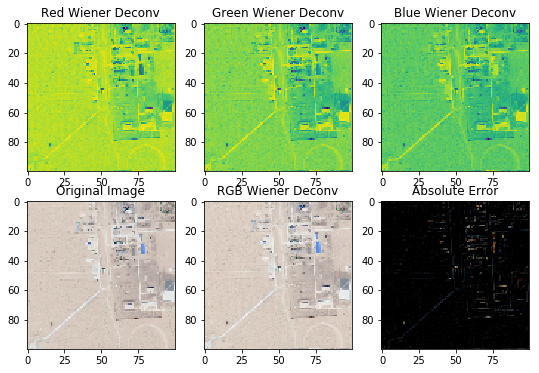

In [84]:
image_original= image[:sx*n:n,:sy*n:n,:]

image_r = image[:sx*n:n,:sy*n:n,0]
image_g = image[:sx*n:n,:sy*n:n,1]
image_b = image[:sx*n:n,:sy*n:n,2]

red_conv = convolve(image_r, psf)
green_conv = convolve(image_g, psf)
blue_conv = convolve(image_b, psf)

red_de_wiener = de_wiener(red_conv, psf,SNR=1e5)
red_de_wiener = red_de_wiener[::-1,::-1]

green_de_wiener = de_wiener(green_conv, psf,SNR=1e5)
green_de_wiener = green_de_wiener[::-1,::-1]

blue_de_wiener = de_wiener(blue_conv, psf,SNR=1e5)
blue_de_wiener = blue_de_wiener[::-1,::-1]

#rgb_de_wiener = zeros(shape=(:sx*n:n,:sy*n:n,3))
rgb_de_wiener = np.stack((red_de_wiener, green_de_wiener, blue_de_wiener), axis = 2)
scaling = np.max(image_orignial)/np.max(np.real(rgb_de_wiener)) 
rgb_de_wiener *= scaling

f, axes = plt.subplots(2,3,figsize=(9,6))

ax_red = axes[0,0]
ax_red.imshow(np.absolute(red_de_wiener))
ax_red.set_title("Red Wiener Deconv")

ax_green = axes[0,1]
ax_green.imshow(np.absolute(green_de_wiener))
ax_green.set_title("Green Wiener Deconv")

ax_blue = axes[0,2]
ax_blue.imshow(np.absolute(blue_de_wiener))
ax_blue.set_title("Blue Wiener Deconv")

ax_orig = axes[1,0]
ax_orig.imshow(np.absolute(image_original))
ax_orig.set_title("Original Image")

ax_rgb = axes[1,1]
ax_rgb.imshow(np.absolute(rgb_de_wiener))
ax_rgb.set_title("RGB Wiener Deconv")

ax_error = axes[1,2]
ax_error.imshow(np.absolute(image_original)-np.absolute(rgb_de_wiener))
ax_error.set_title("Absolute Error")
print("Mean Error: ", np.mean(np.absolute(image_original)-np.absolute(rgb_de_wiener)))

We see the deconvolution looks better when all the channels are included, of course.  The error map shows the errors are concentrated where there are more features, as expected.  But the mean absolute error is 1%, which seems reasonable.

To do this large scale, we might have to divide images into these manageable 100x100 pixel squares and then put them back together, for the sake of keeping the ffts from breaking.

We now have a general idea of a few different techniques for addressing moderate motion blur.  We can choose to further explore any of these in future work.

